In [1]:
import pandas as pd

data_fpath = "../glasgow-simd2020v2.csv"
df = pd.read_csv(data_fpath, header=0)

In [ ]:
# Handle missing data
# Check feature data types etc.

In [4]:
import numpy as np


df_train, df_valid, df_test = np.split(df.sample(frac=1, random_state=1), [int(.7*len(df)), int(.9*len(df))])

print("Training data: {} observations".format(len(df_train)))
print("Validation data: {} observations".format(len(df_valid)))
print("Test data: {} observations".format(len(df_test)))

Training data: 522 observations
Validation data: 149 observations
Test data: 75 observations


In [25]:
from patsy import dmatrices
import statsmodels.api as sm

model_expr = "litter ~ income_count + employment_count + CIF + ALCOHOL + DRUG + SMR + EMERG + no_qualifications + overcrowded_count + nocentralheating_count "

y_train, X_train = dmatrices(model_expr, df_train, return_type="dataframe")
y_valid, X_valid = dmatrices(model_expr, df_valid, return_type="dataframe")

model_train = sm.GLM(y_train, X_train, family=sm.families.Poisson())
results_train = model_train.fit()

print(results_train.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 litter   No. Observations:                  521
Model:                            GLM   Df Residuals:                      510
Model Family:                 Poisson   Df Model:                           10
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -898.83
Date:                Mon, 27 Dec 2021   Deviance:                       1041.5
Time:                        23:23:04   Pearson chi2:                 1.15e+03
No. Iterations:                     5   Pseudo R-squ. (CS):            0.06995
Covariance Type:            nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -0

In [30]:
predictions = results_train.get_prediction(X_valid)
df_predictions = predictions.summary_frame()
predicted_counts, actual_counts = round(df_predictions["mean"]), y_valid["litter"]

print(predicted_counts)

         mean   mean_se  mean_ci_lower  mean_ci_upper
326  1.421427  0.128802       1.190126       1.697681
458  1.346006  0.189682       1.021160       1.774189
465  1.541695  0.197677       1.199104       1.982166
163  0.925958  0.081550       0.779158       1.100417
167  0.903972  0.087041       0.748505       1.091729
..        ...       ...            ...            ...
87   1.455070  0.258040       1.027858       2.059846
655  0.816588  0.085978       0.664325       1.003749
678  1.310538  0.172753       1.012151       1.696890
418  1.320959  0.115769       1.112473       1.568515
288  1.560816  0.229979       1.169313       2.083399

[148 rows x 4 columns]
326    1.0
458    1.0
465    2.0
163    1.0
167    1.0
      ... 
87     1.0
655    1.0
678    1.0
418    1.0
288    2.0
Name: mean, Length: 148, dtype: float64
326    0.0
458    2.0
465    2.0
163    0.0
167    0.0
      ... 
87     2.0
655    1.0
678    0.0
418    3.0
288    6.0
Name: litter, Length: 148, dtype: float64


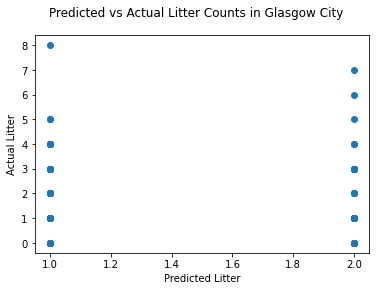

In [31]:
import matplotlib.pyplot as plt

fig = plt.figure()
fig.suptitle("Predicted vs Actual Litter Counts in Glasgow City")
plt.scatter(x=predicted_counts, y=actual_counts)
plt.xlabel("Predicted Litter")
plt.ylabel("Actual Litter")
plt.show()